In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

from openff.interchange.components.interchange import Interchange

In [2]:
# Construct a single-molecule system from toolkit classes
mol = Molecule.from_smiles("CCO")
mol.generate_conformers(n_conformers=1)
top = Topology.from_molecules([mol])
parsley = ForceField("openff-1.0.0.offxml")

off_sys = Interchange.from_smirnoff(force_field=parsley, topology=top)

In [3]:
bonds = off_sys.handlers["Bonds"]

# Transform parameters into matrix representations
p = bonds.get_force_field_parameters()
mapping = bonds.get_mapping()
q = bonds.get_system_parameters()
m = bonds.get_param_matrix()

In [4]:
# force field parameters, each row is something like [k (kcal/mol/A), length (A)]
p

DeviceArray([[5.3113739e+02, 1.5203758e+00],
             [7.5809320e+02, 1.0928884e+00],
             [6.6914154e+02, 1.4142879e+00],
             [1.1205833e+03, 9.7076875e-01]], dtype=float32)

In [5]:
# system parameters, a.k.a. force field parameters as they exist in a parametrized system
q

DeviceArray([[5.3113739e+02, 1.5203758e+00],
             [7.5809320e+02, 1.0928884e+00],
             [7.5809320e+02, 1.0928884e+00],
             [7.5809320e+02, 1.0928884e+00],
             [6.6914154e+02, 1.4142879e+00],
             [7.5809320e+02, 1.0928884e+00],
             [7.5809320e+02, 1.0928884e+00],
             [1.1205833e+03, 9.7076875e-01]], dtype=float32)

In [6]:
# m is the parametrization matrix, which can be dotted with p to get out q
assert np.allclose(m.dot(p.flatten()).reshape((-1, 2)), q)

m

DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [7]:
# save and set initial values
q0 = q
p0 = p

# set learning rate
a = 0.1

In [8]:
from copy import deepcopy

In [9]:
# let jax run with autodiff
_, f_vjp_bonds = jax.vjp(bonds.parametrize, jnp.asarray(p0))  # d/dp

# jax.jvp( ..., has_aux=True) is another approach, but requires that bonds.parametrize returns the indices as well

In [10]:
q_target = deepcopy(q0)
p_target = deepcopy(p0)

# modify a few of the force field targets to arbitrary values;
# this mimic some "true" values we wish to tune to, despite
# these values not being known in real-world fitting
p_target[:, 1] = 0.5 + np.random.rand(4)

# obtain the target _sytem_ parameters by dotting the parametrization
# matrix with target force field values
q_target = m.dot(p_target.flatten()).reshape((-1, 2))

# create a dummy loss function via faking known target parameters;
# in practice this could be the result of an MD run, FE calculation, etc.
def loss(p):
    return jnp.linalg.norm(bonds.parametrize(p) - q_target)

In [11]:
out, f_vjp_bonds = jax.vjp(loss, p0)  # composes a jax.grad

In [12]:
# This also returns loss(p0), which we do not need to store
out == loss(p0)

DeviceArray(True, dtype=bool)

In [13]:
f_vjp_bonds(1.0)

(DeviceArray([[ 0.        ,  0.03217361],
              [ 0.        , -1.2721817 ],
              [ 0.        ,  0.5845848 ],
              [ 0.        ,  0.577526  ]], dtype=float32),)

In [14]:
# this does the same as the jax.vjp above
jax_loss = jax.grad(loss)

jax_loss(p0)  # dL/dp

DeviceArray([[ 0.        ,  0.03217361],
             [ 0.        , -1.2721817 ],
             [ 0.        ,  0.5845848 ],
             [ 0.        ,  0.577526  ]], dtype=float32)

In [15]:
f_vjp_bonds(1.0)[0] == jax_loss(p0)  # dL/dp

DeviceArray([[ True,  True],
             [ True,  True],
             [ True,  True],
             [ True,  True]], dtype=bool)

In [16]:
# derivative of loss function evaluated at the original system parameters;
# note that column 0 mathces target values, so the derivate is flat
f_vjp_bonds(loss(q0))  # dL/dp (!) can be used as gradient in fitting

(DeviceArray([[   0.      ,   12.008647],
              [   0.      , -474.8358  ],
              [   0.      ,  218.19348 ],
              [   0.      ,  215.55882 ]], dtype=float32),)

step 0	loss: 0.8032218813896179
step 10	loss: 0.26887309551239014
step 20	loss: 0.26887327432632446
step 30	loss: 0.26887327432632446
step 40	loss: 0.26887327432632446
step 50	loss: 0.26887327432632446
step 60	loss: 0.26887327432632446
step 70	loss: 0.26887327432632446
step 80	loss: 0.26887327432632446
step 90	loss: 0.26887327432632446


(0.0, 1.5)

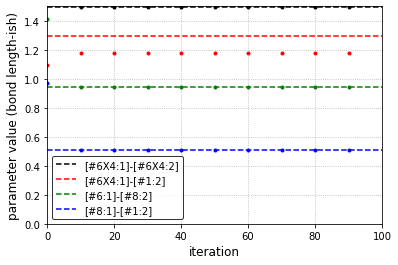

In [17]:
fig, ax = plt.subplots()

# label target values
ax.hlines(p_target[0, 1], 0, 100, color="k", ls="--", label="[#6X4:1]-[#6X4:2]")
ax.hlines(p_target[1, 1], 0, 100, color="r", ls="--", label="[#6X4:1]-[#1:2]")
ax.hlines(p_target[2, 1], 0, 100, color="g", ls="--", label="[#6:1]-[#8:2]")
ax.hlines(p_target[3, 1], 0, 100, color="b", ls="--", label="[#8:1]-[#1:2]")

for i in range(100):
    if i % 10 == 0:
        print(f"step {i}\tloss: {loss(p)}")
        ax.plot(i, p[0][1], "k.")
        ax.plot(i, p[1][1], "r.")
        ax.plot(i, p[2][1], "g.")
        ax.plot(i, p[3][1], "b.")

    # use jax to get the gradient
    _, f_vjp_bonds = jax.vjp(loss, p)
    grad = f_vjp_bonds(1.0)[0]
    # update force field parameters
    p -= a * grad
    # use the parametrization matrix to propagate new
    # force field parameters into new system parameters
    q = m.dot(p.flatten()).reshape((-1, 2))


ax.legend(loc=0)
ax.set_xlabel("iteration")
ax.set_ylabel("parameter value (bond length-ish)")
ax.set_xlim((0, 100))
ax.set_ylim((0, 1.5))

In [18]:
# We can do everything all over again with angles, almost identically
angles = off_sys.handlers["Angles"]
q0 = angles.get_system_parameters()
p0 = angles.get_force_field_parameters()
mapping = angles.get_mapping()
m = angles.get_param_matrix()
q = q0
p = p0
a = 0.1

q_target = deepcopy(q0)
p_target = deepcopy(p0)
p_target[:, 1] = np.random.randint(100, 120, 3)

q_target = angles.parametrize(p_target)


def loss(p):
    return jnp.linalg.norm(angles.parametrize(p) - q_target)

step 0	loss: 21.02607536315918
step 10	loss: 16.632198333740234
step 20	loss: 12.741817474365234
step 30	loss: 9.425061225891113
step 40	loss: 6.769171714782715
step 50	loss: 4.838072299957275
step 60	loss: 3.499711751937866
step 70	loss: 2.4333364963531494
step 80	loss: 1.4277300834655762
step 90	loss: 0.427642822265625


(100.0, 120.0)

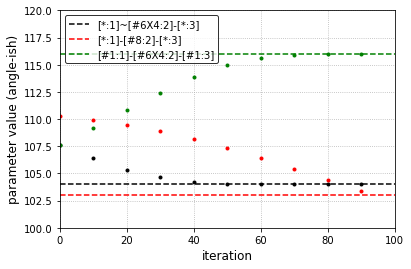

In [19]:
fig, ax = plt.subplots()

# label target values
ax.hlines(p_target[0, 1], 0, 100, color="k", ls="--", label="[*:1]~[#6X4:2]-[*:3]")
ax.hlines(p_target[1, 1], 0, 100, color="r", ls="--", label="[*:1]-[#8:2]-[*:3]")
ax.hlines(p_target[2, 1], 0, 100, color="g", ls="--", label="[#1:1]-[#6X4:2]-[#1:3]")

for i in range(100):
    if i % 10 == 0:
        print(f"step {i}\tloss: {loss(p)}")
        ax.plot(i, p[0][1], "k.")
        ax.plot(i, p[1][1], "r.")
        ax.plot(i, p[2][1], "g.")

    # use jax to get the gradient
    _, f_vjp_angles = jax.vjp(loss, p)
    grad = f_vjp_angles(1.0)[0]
    # update force field parameters
    p -= a * grad
    # print(p[0])
    q = m.dot(p.flatten()).reshape((-1, 2))

ax.legend(loc=0)
ax.set_xlabel("iteration")
ax.set_ylabel("parameter value (angle-ish)")
ax.set_xlim((0, 100))
ax.set_ylim((100, 120))